In [2]:
import netCDF4 as nc4
# from scipy.io import netcdf as nc
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import axes3d
import copy
import pandas as pd
import time as tm
import xarray as xr
import mpl_toolkits as mpl
# import plotly.graph_objects as go
# import plotly.express as px
from scipy import interpolate
import os
import modp as mp
import rasterio
import rasterio.plot
from scipy.optimize import curve_fit
from scipy.stats import linregress

### Verify model climate

In [3]:
nagebins = 51
nszbins = 13
npfts = 2
forest_area_ha = 2000.0
c_to_biomass = 2.0
m2_to_ha = 10000.0
abg_frac = 0.6

# nens = len(candidates)
nens = 254
# Initial candidates, i.e., all members
can_idx_all = np.arange(0,nens)

# Get multi-annual mean instead of time series
get_mean = False
# Temporary diagnosis
diagnosis = False
# More FATES output variables which are inactive by default
additional_vars = False

# Path to all ensemble members
block_n = 1
# block_ens = [210, 210, 218]
block_ens = [254]

# Path to all ensemble members
block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_mxbreeding254_spinup_2024-09-12_e9515ed7a8_d8f0eb12/run/']
block_prefix = ['fates_mxbreeding254_spinup_2024-09-12_e9515ed7a8_d8f0eb12.elm_']

# block_path = ['/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/', \
#               '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/', \
#               '/pscratch/sd/s/sshu3/FATES_MRV/fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12/run/']
# block_prefix = ['fates_uav_mxbreeding638_1_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_',\
#                'fates_uav_mxbreeding638_2_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_', \
#                'fates_uav_mxbreeding638_3_spinup_2024-10-26_e9515ed7a8_d8f0eb12.elm_']


# Year number of model outputs
# fyear = [1850, 1855, 1860, 1865, 1870, 1875, 1880, 1885
        # , 1890, 1895, 1900, 1905, 1910, 1915, 1920
        # , 1925, 1930, 1935, 1940, 1945
        # , 1950, 1955, 1960, 1965, 1970, 1975, 1980
        # , 1985, 1990, 1995, 2000, 2005, 2008, 2013, 2018] 
# fyear = [201, 301, 401, 501]
fyear = [2023, 2028, 2033]
nyr = len(fyear)*5
beg_year = fyear[0]
end_year = fyear[len(fyear)-1]+5

# Functions
def moving_average(a, n=10) :
    """
    Quick moving average function
    # a - input array
    # n - the window of moving average
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [4]:
# Open the first file and read metadata
fpath = block_path[0]+block_prefix[0]+'0001.h0.'+str(fyear[0]).zfill(4)+'-02-01-00000.nc'
dtc = nc4.Dataset(fpath)
patch_age_bins = dtc['fates_levage'][:]
cohort_size_bins = dtc['fates_levscls'][:]
dtc.close()

In [5]:
# Open the file and obtain the time series
# This step will take longer than expected.
start = tm.time()
    
# Var lists
# CLimate vars
tbot_collect = []
pco2_collect = []
pbot_collect = []
fsds_collect = []
rain_collect = []
snow_collect = []

# Key vars
num_sz_collect = []
time_collect = []
height_ca_collect = []
height_ba_collect = []
gpp_collect = []
gpp_bl_collect = []
gpp_nl_collect = []
npp_collect = []
npp_bl_collect = []
npp_nl_collect = []
age_patch_collect = []
age_collect = []
can_area_collect = []
lai_collect = []
lai_age_collect = []
vegc_collect = []
vegc_bl_collect = []
vegc_nl_collect = []
leafc_collect = []
leafc_bl_collect = []
leafc_nl_collect = []
reprodc_collect = []
sapwoodc_collect = []
storec_collect = []
frc_collect = []
rec_collect = []
mort_pf_collect = []
mort_collect = []
mort_ustory_collect = []
ba_collect = []
num_can_sz_collect = []
num_ustory_sz_collect = []
ddbh_can_sz_collect = []
ddbh_ustory_sz_collect = []
litter_collect = []
spread_collect = []
soilc_collect = []
logging_rate_collect = []
sec_frac_collect = []
harvested_wood_product_collect = []
germ_collect = []
if(additional_vars):
    woodnpp_collect = []
    promote_collect = []
    demote_collect = []

# Loop through members and collect the time series
# for i in np.arange(0,len(candidates)):
for k in np.arange(0,block_n):
    for i in np.arange(0,block_ens[k]):
        for j in np.arange(0, len(fyear)):
            ens_num = str(i+1).zfill(4)
    #     print('Current block number: ', k)
    #     print('Current ens_num number: ', ens)
            fpath = block_path[k]+block_prefix[k]+ens_num+'.h0.'+str(fyear[j]).zfill(4)+'-02-01-00000.nc'
            dtc = nc4.Dataset(fpath)
            dtime = dtc['time'][:]
            # Climate 
            dtbot = dtc['TBOT'][:]
            dpco2 = dtc['PCO2'][:]
            dpbot = dtc['PBOT'][:]
            dfsds = dtc['FSDS'][:]
            drain = dtc['RAIN'][:]
            dsnow = dtc['SNOW'][:]
            # Main
            dnum_sz = dtc['FATES_NPLANT_SZ'][:]
            dgpp = dtc['FATES_GPP'][:]
            dgpp_pf = dtc['FATES_GPP_PF'][:]
            dnpp = dtc['FATES_NPP'][:]
            dnpp_pf = dtc['FATES_NPP_PF'][:]
            dlai = dtc['FATES_LAI'][:]
            dlai_age = dtc['FATES_LAI_AP'][:]
            dleafc = dtc['FATES_LEAFC'][:]
            dleafc_pf = dtc['FATES_LEAFC_PF'][:]
            dheight_ba = dtc['FATES_BA_WEIGHTED_HEIGHT'][:]
            dheight_ca = dtc['FATES_CA_WEIGHTED_HEIGHT'][:]
            dvegc = dtc['FATES_VEGC'][:]
            dvegc_pf = dtc['FATES_VEGC_PF'][:]
            dreprodc = dtc['FATES_REPROC'][:]
            dsapwoodc = dtc['FATES_SAPWOODC'][:]
            dstorec = dtc['FATES_STOREC'][:]
            dfrc = dtc['FATES_FROOTC'][:]
            drec = dtc['FATES_RECRUITMENT_PF'][:]
            dmort = dtc['FATES_MORTALITY_CANOPY_SZ'][:]
            dmort_pf = dtc['FATES_MORTALITY_PF'][:]
            dmort_ustory = dtc['FATES_MORTALITY_USTORY_SZ'][:]
            dba = dtc['FATES_BASALAREA_SZ'][:]
            dnum_can_sz = dtc['FATES_NPLANT_CANOPY_SZ'][:]
            dnum_ustory_sz = dtc['FATES_NPLANT_USTORY_SZ'][:]
            ddbh_can_sz = dtc['FATES_DDBH_CANOPY_SZ'][:]
            ddbh_ustory_sz = dtc['FATES_DDBH_USTORY_SZ'][:]
            dlitter = dtc['FATES_LITTER_OUT'][:]
            dsoilc = dtc['TOTSOMC_1m'][:]
            dspread = dtc['FATES_CANOPY_SPREAD'][:]
            dage_patch = dtc['FATES_PATCHAREA_AP'][:]
            dage = dtc['FATES_SECONDAREA_ANTHRODIST_AP'][:]
            dcan_area = dtc['FATES_CANOPYAREA_AP'][:]
            dlogging_rate = dtc['FATES_DISTURBANCE_RATE_LOGGING'][:]
            dsec_frac = dtc['FATES_SECONDARY_FOREST_FRACTION'][:]
            dwood_prod = dtc['FATES_HARVEST_CARBON_FLUX'][:]
            dgerm = dtc['FATES_SEED_GERM_EL'][:]
            # Non-default outputs
            if(additional_vars):
                dwoodnpp = dtc['FATES_SAPWOOD_ALLOC_CANOPY_SZ'][:]
                dpromote = dtc['FATES_PROMOTION_RATE_SZ'][:]
                ddemote = dtc['FATES_DEMOTION_RATE_SZ'][:]
            dtc.close()

            # Concatenate into same time series
            if(j == 0):
                dtime_comb = copy.deepcopy(dtime)
                dtbot_comb = copy.deepcopy(dtbot)
                dpco2_comb = copy.deepcopy(dpco2)
                dpbot_comb = copy.deepcopy(dpbot)
                dfsds_comb = copy.deepcopy(dfsds)
                drain_comb = copy.deepcopy(drain)
                dsnow_comb = copy.deepcopy(dsnow)
                dgpp_comb = copy.deepcopy(dgpp)
                dgpp_pf_comb = copy.deepcopy(dgpp_pf)
                dnpp_comb = copy.deepcopy(dnpp)
                dnpp_pf_comb = copy.deepcopy(dnpp_pf)
                dlai_comb = copy.deepcopy(dlai)
                dlai_age_comb = copy.deepcopy(dlai_age)
                dleafc_comb = copy.deepcopy(dleafc)
                dleafc_pf_comb = copy.deepcopy(dleafc_pf)
                dheight_ba_comb = copy.deepcopy(dheight_ba)
                dheight_ca_comb = copy.deepcopy(dheight_ca)
                dvegc_comb = copy.deepcopy(dvegc)
                dvegc_pf_comb = copy.deepcopy(dvegc_pf)
                dreprodc_comb = copy.deepcopy(dreprodc)
                dsapwoodc_comb = copy.deepcopy(dsapwoodc)
                dstorec_comb = copy.deepcopy(dstorec)
                dfrc_comb = copy.deepcopy(dfrc)
                drec_comb = copy.deepcopy(drec)
                dmort_comb = copy.deepcopy(dmort)
                dmort_pf_comb = copy.deepcopy(dmort_pf)
                dmort_ustory_comb = copy.deepcopy(dmort_ustory)
                dba_comb = copy.deepcopy(dba)
                dnum_can_sz_comb = copy.deepcopy(dnum_can_sz)
                dnum_sz_comb = copy.deepcopy(dnum_sz)
                dnum_ustory_sz_comb = copy.deepcopy(dnum_ustory_sz)
                ddbh_can_sz_comb = copy.deepcopy(ddbh_can_sz)
                ddbh_ustory_sz_comb = copy.deepcopy(ddbh_ustory_sz)
                dlitter_comb = copy.deepcopy(dlitter)
                dspread_comb = copy.deepcopy(dspread)
                dsoilc_comb = copy.deepcopy(dsoilc)
                dage_patch_comb = copy.deepcopy(dage_patch)
                dage_comb = copy.deepcopy(dage)
                dcan_area_comb = copy.deepcopy(dcan_area)
                dlogging_rate_comb = copy.deepcopy(dlogging_rate)
                dsec_frac_comb = copy.deepcopy(dsec_frac)
                dwood_product_comb = copy.deepcopy(dwood_prod)
                dgerm_comb = copy.deepcopy(dgerm)
                # Non-default outputs
                if(additional_vars):
                    dwoodnpp_comb = copy.deepcopy(dwoodnpp)
                    dpromote_comb = copy.deepcopy(dpromote)
                    ddemote_comb = copy.deepcopy(ddemote)
            else:
                dtime_comb = np.append(dtime_comb, dtime, axis = 0)
                dtbot_comb = np.append(dtbot_comb, dtbot, axis = 0)
                dpco2_comb = np.append(dpco2_comb, dpco2, axis = 0)
                dpbot_comb = np.append(dpbot_comb, dpbot, axis = 0)
                dfsds_comb = np.append(dfsds_comb, dfsds, axis = 0)
                drain_comb = np.append(drain_comb, drain, axis = 0)
                dsnow_comb = np.append(dsnow_comb, dsnow, axis = 0)
                dgpp_comb = np.append(dgpp_comb, dgpp, axis = 0)
                dgpp_pf_comb = np.append(dgpp_pf_comb, dgpp_pf, axis = 0)
                dnpp_comb = np.append(dnpp_comb, dnpp, axis = 0)
                dnpp_pf_comb = np.append(dnpp_pf_comb, dnpp_pf, axis = 0)
                dlai_comb = np.append(dlai_comb, dlai, axis = 0)
                dlai_age_comb = np.append(dlai_age_comb, dlai_age, axis = 0)
                dleafc_comb = np.append(dleafc_comb, dleafc, axis = 0)
                dleafc_pf_comb = np.append(dleafc_pf_comb, dleafc_pf, axis = 0)
                dheight_ba_comb = np.append(dheight_ba_comb, dheight_ba, axis = 0)
                dheight_ca_comb = np.append(dheight_ca_comb, dheight_ca, axis = 0)
                dvegc_comb = np.append(dvegc_comb, dvegc, axis = 0)
                dvegc_pf_comb = np.append(dvegc_pf_comb, dvegc_pf, axis = 0)
                dreprodc_comb = np.append(dreprodc_comb, dreprodc, axis = 0)
                dsapwoodc_comb = np.append(dsapwoodc_comb, dsapwoodc, axis = 0)
                dstorec_comb = np.append(dstorec_comb, dstorec, axis = 0)
                dfrc_comb = np.append(dfrc_comb, dfrc, axis = 0)
                drec_comb = np.append(drec_comb, drec, axis = 0)
                dmort_comb = np.append(dmort_comb, dmort, axis = 0)
                dmort_pf_comb = np.append(dmort_pf_comb, dmort_pf, axis = 0)
                dmort_ustory_comb = np.append(dmort_ustory_comb, dmort_ustory, axis = 0)
                dba_comb = np.append(dba_comb, dba, axis = 0)
                dnum_can_sz_comb = np.append(dnum_can_sz_comb, dnum_can_sz, axis = 0)
                dnum_sz_comb = np.append(dnum_sz_comb, dnum_sz, axis = 0)
                dnum_ustory_sz_comb = np.append(dnum_ustory_sz_comb, dnum_ustory_sz, axis = 0)
                ddbh_can_sz_comb = np.append(ddbh_can_sz_comb, ddbh_can_sz, axis = 0)
                ddbh_ustory_sz_comb = np.append(ddbh_ustory_sz_comb, ddbh_ustory_sz, axis = 0)
                dlitter_comb = np.append(dlitter_comb, dlitter, axis = 0)
                dspread_comb = np.append(dspread_comb, dspread, axis = 0)
                dsoilc_comb = np.append(dsoilc_comb, dsoilc, axis = 0)
                dage_patch_comb = np.append(dage_patch_comb, dage_patch, axis=0)
                dage_comb = np.append(dage_comb, dage, axis = 0)
                dcan_area_comb = np.append(dcan_area_comb, dcan_area, axis = 0)
                dlogging_rate_comb = np.append(dlogging_rate_comb, dlogging_rate, axis=0)
                dsec_frac_comb = np.append(dsec_frac_comb, dsec_frac, axis=0)
                dwood_product_comb = np.append(dwood_product_comb, dwood_prod, axis=0)
                dgerm_comb = np.append(dgerm_comb, dgerm, axis=0)
                # Non-default outputs
                if(additional_vars):
                    dwoodnpp_comb = np.append(dwoodnpp_comb, dwoodnpp, axis=0)
                    dpromote_comb = np.append(dpromote_comb, dpromote, axis=0)
                    ddemote_comb = np.append(ddemote_comb, ddemote, axis=0)

        # Obtain the mean results
        if(get_mean):
            time_collect.append(np.nanmean(dtime[:]))
            tbot_collect.append(np.nanmean(dtbot[:,0]))
            pco2_collect.append(np.nanmean(dpco2[:,0]))
            pbot_collect.append(np.nanmean(dpbot[:,0]))
            fsds_collect.append(np.nanmean(dfsds[:,0]))
            rain_collect.append(np.nanmean(drain[:,0]))
            snow_collect.append(np.nanmean(dsnow[:,0]))
            gpp_collect.append(np.nanmean(dgpp[:,0])*3600*24*365)
            gpp_bl_collect.append(np.nanmean(dgpp_pf[:,0,0])*3600*24*365)
            gpp_nl_collect.append(np.nanmean(dgpp_pf[:,1,0])*3600*24*365)
            npp_collect.append(np.nanmean(dnpp[:,0])*3600*24*365)
            npp_bl_collect.append(np.nanmean(dnpp_pf[:,0,0])*3600*24*365)
            npp_nl_collect.append(np.nanmean(dnpp_pf[:,1,0])*3600*24*365)
            lai_collect.append(np.nanmean(dlai[:,0]))
            lai_age_collect.append(np.nanmean(np.nansum(dlai_age[:,:,0], axis=1)))
            leafc_collect.append(np.nanmean(dleafc[:,0]))
            leafc_bl_collect.append(np.nanmean(dleafc_pf[:,0,0]))
            leafc_nl_collect.append(np.nanmean(dleafc_pf[:,1,0]))
            vegc_collect.append(np.nanmean(dvegc[:,0]))
            vegc_bl_collect.append(np.nanmean(dvegc_pf[:,0,0]))
            vegc_nl_collect.append(np.nanmean(dvegc_pf[:,1,0]))
            height_ca_collect.append(np.nanmean(dheight_ca[:,0]))
            height_ba_collect.append(np.nanmean(dheight_ba[:,0]))
            reprodc_collect.append(np.nanmean(dreprodc[:,0]))
            sapwoodc_collect.append(np.nanmean(dsapwoodc[:,0]))
            storec_collect.append(np.nanmean(dstorec[:,0]))
            frc_collect.append(np.nanmean(dfrc[:,0]))
            rec_collect.append(np.nanmean(np.nansum(drec[:,:,0], axis=1)))
            mort_collect.append(np.nanmean(np.nansum(dmort[:,:,0], axis=1)))
            mort_pf_collect.append(np.nanmean(np.nansum(dmort_pf[:,:,0], axis=1)))
            mort_ustory_collect.append(np.nanmean(np.nansum(dmort_ustory[:,:,0], axis=1)))
            ba_collect.append(np.nanmean(np.nansum(dba[:,:,0], axis=1)))
            num_sz_collect.append(np.nanmean(dnum_sz[:,:,0], axis = 1))
            num_can_sz_collect.append(np.nanmean(np.nansum(dnum_can_sz[:,:,0], axis=1)))
            num_ustory_sz_collect.append(np.nanmean(np.nansum(dnum_ustory_sz[:,:,0], axis=1)))
            ddbh_can_sz_collect.append(np.nanmean(np.nansum(ddbh_can_sz[:,:,0], axis=1)))
            ddbh_ustory_sz_collect.append(np.nanmean(np.nansum(ddbh_ustory_sz[:,:,0], axis=1)))
            litter_collect.append(np.nanmean(dlitter[:,0]))
            soilc_collect.append(np.nanmean(dsoilc[:,0]*0.001))
            spread_collect.append(np.nanmean(dspread[:,0]))
            age_patch_collect.append(np.nanmean(np.nansum(dage_patch[:,:,0], axis=1)))
            age_collect.append(np.nanmean(np.nansum(dage[:,:,0], axis=1)))
            can_area_collect.append(np.nanmean(np.nansum(dcan_area[:,:,0], axis=1)))
            logging_rate_collect.append(np.nanmean(np.nansum(dlogging_rate[:,0], axis=0)))
            sec_frac_collect.append(np.nanmean(np.nansum(dsec_frac[:,0], axis=0)))
            harvested_wood_product_collect.append(np.nanmean(np.nansum(dwood_product_comb[:,0], axis=0)))
            germ_collect.append(np.nanmean(np.nansum(dgerm_comb[:,0], axis=0)))
            # Non-default outputs
            if(additional_vars):
                woodnpp_collect.append(np.nanmean(np.nansum(dwoodnpp_comb[:,0], axis=0)))
                promote_collect.append(np.nanmean(np.nansum(dpromote_comb[:,:,0], axis=1)))
                demote_collect.append(np.nanmean(np.nansum(ddemote_comb[:,:,0], axis=1)))
        else:
            # Obtain the time series
            time_collect.append(dtime_comb[:])
            tbot_collect.append(dtbot_comb[:])
            pco2_collect.append(dpco2_comb[:])
            pbot_collect.append(dpbot_comb[:])
            fsds_collect.append(dfsds_comb[:])
            rain_collect.append(drain_comb[:])
            snow_collect.append(dsnow_comb[:])
            gpp_collect.append(dgpp_comb[:]*3600*24*365)
            gpp_bl_collect.append(dgpp_pf_comb[:,0]*3600*24*365)
            gpp_nl_collect.append(dgpp_pf_comb[:,1]*3600*24*365)
            npp_collect.append(dnpp_comb[:]*3600*24*365)
            npp_bl_collect.append(dnpp_pf_comb[:,0]*3600*24*365)
            npp_nl_collect.append(dnpp_pf_comb[:,1]*3600*24*365)
            lai_collect.append(dlai_comb[:])
            lai_age_collect.append(dlai_age_comb[:,:])
            leafc_collect.append(dleafc_comb[:])
            leafc_bl_collect.append(dleafc_pf_comb[:,0])
            leafc_nl_collect.append(dleafc_pf_comb[:,1])
            vegc_collect.append(dvegc_comb[:])
            vegc_bl_collect.append(dvegc_pf_comb[:,0])
            vegc_nl_collect.append(dvegc_pf_comb[:,1])
            height_ca_collect.append(dheight_ca_comb[:,0])
            height_ba_collect.append(dheight_ba_comb[:,0])
            reprodc_collect.append(dreprodc_comb[:])
            sapwoodc_collect.append(dsapwoodc_comb[:])
            storec_collect.append(dstorec_comb[:])
            frc_collect.append(dfrc_comb[:])
            rec_collect.append(drec_comb[:,:])
            mort_collect.append(dmort_comb[:,:])
            mort_pf_collect.append(dmort_pf_comb[:,:])
            mort_ustory_collect.append(dmort_ustory_comb[:,:])
            ba_collect.append(dba_comb[:,:])
            num_can_sz_collect.append(dnum_can_sz_comb[:,:])
            num_sz_collect.append(dnum_sz_comb[:,:])
            num_ustory_sz_collect.append(dnum_ustory_sz_comb[:,:])
            ddbh_can_sz_collect.append(ddbh_can_sz_comb[:,:])
            ddbh_ustory_sz_collect.append(ddbh_ustory_sz_comb[:,:])
            litter_collect.append(dlitter_comb[:])
            spread_collect.append(dspread_comb[:])
            soilc_collect.append(dsoilc_comb[:]*0.001)
            age_patch_collect.append(dage_patch_comb[:,:])
            age_collect.append(dage_comb[:,:])
            can_area_collect.append(dcan_area_comb[:,:])
            logging_rate_collect.append(dlogging_rate_comb[:])
            sec_frac_collect.append(dsec_frac_comb[:])
            harvested_wood_product_collect.append(dwood_product_comb[:])
            germ_collect.append(dgerm_comb[:])
            # Non-default outputs
            if(additional_vars):
                woodnpp_collect.append(dwoodnpp_comb[:])
                promote_collect.append(dpromote_comb[:,:])
                demote_collect.append(ddemote_comb[:,:])
        
# transfer into np array 
arr_num_sz = np.array(num_sz_collect)
arr_time = np.array(time_collect)
arr_tbot = np.array(tbot_collect)
arr_pco2 = np.array(pco2_collect)
arr_pbot = np.array(pbot_collect)
arr_fsds = np.array(fsds_collect)
arr_rain = np.array(rain_collect)
arr_snow = np.array(snow_collect)
arr_gpp = np.array(gpp_collect)
arr_gpp_bl = np.array(gpp_bl_collect)
arr_gpp_nl = np.array(gpp_nl_collect)
arr_npp = np.array(npp_collect)
arr_npp_bl = np.array(npp_bl_collect)
arr_npp_nl = np.array(npp_nl_collect)
arr_lai = np.array(lai_collect)
arr_lai_age = np.array(lai_age_collect)
arr_leafc = np.array(leafc_collect)
arr_leafc_bl = np.array(leafc_bl_collect)
arr_leafc_nl = np.array(leafc_nl_collect)
arr_height_ca = np.array(height_ca_collect)
arr_height_ba = np.array(height_ba_collect)
arr_vegc = np.array(vegc_collect)
arr_vegc_bl = np.array(vegc_bl_collect)
arr_vegc_nl = np.array(vegc_nl_collect)
arr_reprodc = np.array(reprodc_collect)
arr_sapwoodc = np.array(sapwoodc_collect)
arr_storec = np.array(storec_collect)
arr_frc = np.array(frc_collect)
arr_rec = np.array(rec_collect)
arr_mort = np.array(mort_collect)
arr_mort_pf = np.array(mort_pf_collect)
arr_mort_ustory = np.array(mort_ustory_collect)
arr_ba = np.array(ba_collect)
arr_num_can_sz = np.array(num_can_sz_collect)
arr_num_ustory_sz = np.array(num_ustory_sz_collect)
arr_ddbh_can_sz = np.array(ddbh_can_sz_collect)
arr_ddbh_ustory_sz = np.array(ddbh_ustory_sz_collect)
arr_spread = np.array(spread_collect)
arr_litter = np.array(litter_collect)
arr_soilc = np.array(soilc_collect)
arr_age_patch = np.array(age_patch_collect)
arr_age = np.array(age_collect)
arr_can_area = np.array(can_area_collect)
arr_logging_rate = np.array(logging_rate_collect)
arr_sec_frac = np.array(sec_frac_collect)
arr_wood_product = np.array(harvested_wood_product_collect)
arr_germ = np.array(germ_collect)
# Non-default outputs
if(additional_vars):
    arr_woodnpp = np.array(woodnpp_collect)
    arr_promote = np.array(promote_collect)
    arr_demote = np.array(demote_collect)

end = tm.time()
print('Time elapsed: ', end - start)

Time elapsed:  155.13216829299927


In [11]:
## Calculate annual average
age_annual_mean = np.zeros((nens,nyr,nagebins))
age_patch_mean = np.zeros((nens,nyr,nagebins))
arr_tbot_mean = np.zeros((nens,nyr))
arr_pco2_mean = np.zeros((nens,nyr))
arr_pbot_mean = np.zeros((nens,nyr))
arr_fsds_mean = np.zeros((nens,nyr))
arr_rain_mean = np.zeros((nens,nyr))
arr_snow_mean = np.zeros((nens,nyr))
arr_gpp_nl_mean = np.zeros((nens,nyr))
arr_gpp_bl_mean = np.zeros((nens,nyr))
arr_vegc_nl_mean = np.zeros((nens,nyr))
arr_vegc_bl_mean = np.zeros((nens,nyr))
arr_soilc_mean = np.zeros((nens,nyr))
arr_logging_rate_mean = np.zeros((nens,nyr))
arr_sec_frac_mean = np.zeros((nens,nyr))
arr_num_sz_mean = np.zeros((nens,nyr,nszbins))
arr_num_can_sz_mean = np.zeros((nens,nyr,nszbins))
arr_num_ustory_sz_mean = np.zeros((nens,nyr,nszbins))
arr_rec_mean = np.zeros((nens,nyr,npfts))
arr_mort_can_mean = np.zeros((nens,nyr,nszbins))
arr_mort_ustory_mean = np.zeros((nens,nyr,nszbins))
arr_germ_mean = np.zeros((nens,nyr))
arr_ddbh_can_mean = np.zeros((nens,nyr,nszbins))
arr_ddbh_ustory_mean = np.zeros((nens,nyr,nszbins))
arr_wood_product_mean = np.zeros((nens,nyr))
# Non-default outputs
if(additional_vars):
    arr_woodnpp_mean = np.zeros((nens,nyr))
    arr_promote_mean = np.zeros((nens,nyr,nszbins))
    arr_demote_mean = np.zeros((nens,nyr,nszbins))
for iyr in np.arange(0,nyr):
    age_annual_mean[:,iyr,:] = np.nanmean(arr_age[:,12*iyr:12+12*iyr,:,0], axis=1)
    age_patch_mean[:,iyr,:] = np.nanmean(arr_age_patch[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_tbot_mean[:,iyr] =  np.nanmean(arr_tbot[:,12*iyr:12+12*iyr,0], axis=1)
    arr_pco2_mean[:,iyr] =  np.nanmean(arr_pco2[:,12*iyr:12+12*iyr,0], axis=1)
    arr_pbot_mean[:,iyr] =  np.nanmean(arr_pbot[:,12*iyr:12+12*iyr,0], axis=1)
    arr_fsds_mean[:,iyr] =  np.nanmean(arr_fsds[:,12*iyr:12+12*iyr,0], axis=1)
    arr_rain_mean[:,iyr] =  np.nanmean(arr_rain[:,12*iyr:12+12*iyr,0], axis=1)
    arr_snow_mean[:,iyr] =  np.nanmean(arr_snow[:,12*iyr:12+12*iyr,0], axis=1)
    arr_gpp_nl_mean[:,iyr] = np.nanmean(arr_gpp_nl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_gpp_bl_mean[:,iyr] = np.nanmean(arr_gpp_bl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_vegc_nl_mean[:,iyr] = np.nanmean(arr_vegc_nl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_vegc_bl_mean[:,iyr] = np.nanmean(arr_vegc_bl[:,12*iyr:12+12*iyr,0], axis=1)
    arr_soilc_mean[:,iyr] = np.nanmean(arr_soilc[:,12*iyr:12+12*iyr,0], axis=1)
    arr_logging_rate_mean[:,iyr] = np.nanmean(arr_logging_rate[:,12*iyr:12+12*iyr,0], axis=1)
    arr_sec_frac_mean[:,iyr] = np.nanmean(arr_sec_frac[:,12*iyr:12+12*iyr,0], axis=1)
    arr_num_sz_mean[:, iyr, :] = np.nanmean(arr_num_sz[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_num_can_sz_mean[:, iyr, :] = np.nanmean(arr_num_can_sz[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_num_ustory_sz_mean[:, iyr, :] = np.nanmean(arr_num_ustory_sz[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_rec_mean[:, iyr, :] = np.nanmean(arr_rec[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_mort_can_mean[:, iyr, :] = np.nanmean(arr_mort[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_mort_ustory_mean[:, iyr, :] =  np.nanmean(arr_mort_ustory[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_ddbh_can_mean[:, iyr, :] = np.nanmean(arr_ddbh_can_sz[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_ddbh_ustory_mean[:, iyr, :] = np.nanmean(arr_ddbh_ustory_sz[:,12*iyr:12+12*iyr,:,0], axis=1)
    arr_germ_mean[:, iyr] = np.nanmean(arr_germ[:,12*iyr:12+12*iyr,0,0], axis=1)
    arr_wood_product_mean[:, iyr] = np.nanmean(arr_wood_product[:,12*iyr:12+12*iyr,0], axis=1)
    # Non-default outputs
    if(additional_vars):
        arr_woodnpp_mean[:, iyr, :] = np.nanmean(arr_woodnpp[:,12*iyr:12+12*iyr,0], axis=1)
        arr_promote_mean[:, iyr, :] = np.nanmean(arr_promote[:,12*iyr:12+12*iyr,:,0], axis=1)
        arr_demote_mean[:, iyr, :] = np.nanmean(arr_demote[:,12*iyr:12+12*iyr,:,0], axis=1)

# CO2 in ppm, for validation
arr_co2_ppm = arr_pco2_mean[:,:]/arr_pbot_mean[:,:]*1000000

# Age structure   
age_bin = np.arange(1,52)
ax_yr = np.arange(1850,1850+nyr)
age_yr = np.zeros((nens,nyr))
for iyr in np.arange(0,nyr):
    for j in np.arange(0,nens):
        for k in np.arange(0,51):
            age_yr[j,iyr] = age_yr[j,iyr] + age_bin[k] * age_annual_mean[j,iyr,k]

In [8]:
# Open the climate forcing data
f_clim_bias_corr = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp585_final/'
# f_clim_bias_corr = '/pscratch/sd/s/sshu3/cesm_input_datasets/atm/datm7/sanrafael_e3sm_ssp126_final/'
f_suf = '.nc'

# First open all data needed and concatenate into monthly time series
jday_beg = [0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]
jday_end = [31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334, 365]
jday_cnt = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

rain_out = 'PRECTmms'
sw_out = 'FSDS'
lw_out = 'FLDS'
temp_out = 'TBOT'
wind_out = 'WIND'
pres_out = 'PSRF'
q_out = 'RH'

sr_tbot_ssp = []
sr_wind_ssp = []
sr_rh_ssp = []
sr_pbot_ssp = []
sr_rain_ssp = []
sr_sw_ssp = []
sr_lw_ssp = []

# Get the whole time series
yrbeg = 2023
yrend = 2038

# E3SMv1 - 3 hourly -> monthly
for i in np.arange(yrbeg,yrend):
    for j in np.arange(1,13):
        if(j < 10):
            fp = f_clim_bias_corr+str(i)+'-0'+str(j)+f_suf
        else:
            fp = f_clim_bias_corr+str(i)+'-'+str(j)+f_suf
        dtc = nc4.Dataset(fp)
        if(i == yrbeg and j == 1):
            sr_tbot_ssp = np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0])) 
            sr_wind_ssp = np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))
            sr_rh_ssp = np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))
            sr_pbot_ssp = np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))
            sr_rain_ssp = np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))
            sr_sw_ssp = np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))
            sr_lw_ssp = np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))
        else:
            sr_tbot_ssp = np.concatenate((sr_tbot_ssp, np.atleast_1d(np.nanmean(dtc[temp_out][:,0,0]))))
            sr_wind_ssp = np.concatenate((sr_wind_ssp, np.atleast_1d(np.nanmean(dtc[wind_out][:,0,0]))))
            sr_rh_ssp = np.concatenate((sr_rh_ssp, np.atleast_1d(np.nanmean(dtc[q_out][:,0,0]))))
            sr_pbot_ssp = np.concatenate((sr_pbot_ssp, np.atleast_1d(np.nanmean(dtc[pres_out][:,0,0]))))
            sr_rain_ssp = np.concatenate((sr_rain_ssp, np.atleast_1d(np.nanmean(dtc[rain_out][:,0,0]))))
            sr_sw_ssp = np.concatenate((sr_sw_ssp, np.atleast_1d(np.nanmean(dtc[sw_out][:,0,0]))))
            sr_lw_ssp = np.concatenate((sr_lw_ssp, np.atleast_1d(np.nanmean(dtc[lw_out][:,0,0]))))
        dtc.close()

# Obtain annual mean
tbot_ssp_mean = np.zeros((nyr))
sw_ssp_mean = np.zeros((nyr))
rain_ssp_mean = np.zeros((nyr))
for iyr in np.arange(0,nyr):
    tbot_ssp_mean[iyr] = np.nanmean(sr_tbot_ssp[12*iyr:12+12*iyr], axis=0)
    sw_ssp_mean[iyr] = np.nanmean(sr_sw_ssp[12*iyr:12+12*iyr], axis=0)
    rain_ssp_mean[iyr] = np.nanmean(sr_rain_ssp[12*iyr:12+12*iyr], axis=0)


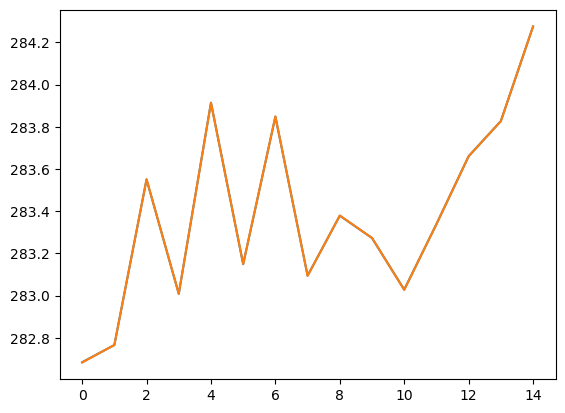

In [9]:
# Make plot and see if they can match each other
# Temperature
plt.plot(arr_tbot_mean[0,:])
plt.plot(tbot_ssp_mean)

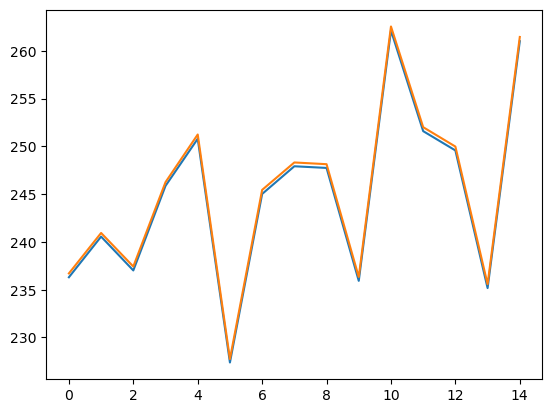

In [12]:
# Solar radiation (SW)
plt.plot(arr_fsds_mean[0,:])
plt.plot(sw_ssp_mean)

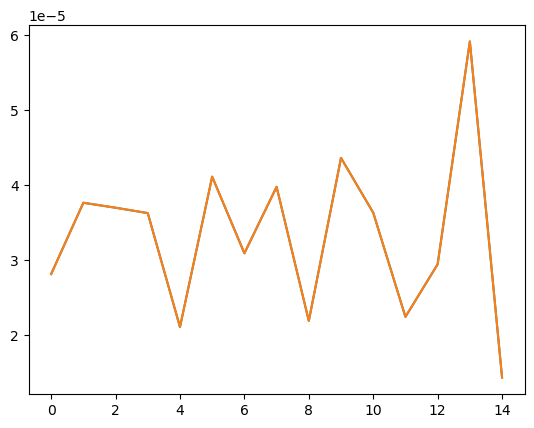

In [15]:
# Precipitation
plt.plot(arr_rain_mean[0,:]+arr_snow_mean[0,:])
plt.plot(rain_ssp_mean)